

---



---



---



**Загрузка данных**

In [ ]:
from skimage.segmentation import felzenszwalb
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kostyasereginmailru","key":"ad05ad97cdde449caa2e57874c5b2819"}'}

In [ ]:
%%capture
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection/

 18% 5.00M/28.4M [00:00<00:00, 34.0MB/s]
100% 28.4M/28.4M [00:00<00:00, 121MB/s] 


In [ ]:
!unzip -qq /content/fruit-images-for-object-detection.zip



---



---



---



In [ ]:
train = '/content/train_zip/train'
test = '/content/test_zip/test'

**Создание функций**

In [ ]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.float()

In [ ]:
def f(x):
    # разделяем на 2 списка: jpg и xml
    # list_pic = []
    # list_ann = []
    # lst = [str(i) for i in Glob(x)]
    # for i in lst:
    #   if i.split('.')[1] == 'jpg':
    #     list_pic.append(i)
    #   else:
    #     list_ann.append(i)
    # assert len(list_pic) == len(list_ann)
    self.root = root
    self.transforms = transforms
    self.list_pic = sorted(Glob(self.root + '/*.jpg'))
    self.list_ann = sorted(Glob(self.root + '/*.xml'))
    #--------
    picture =[]
    way_pic =[]
    way_ann =[]
    target = []
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    width = []
    height = []

    for i in list_ann:
      tree = ET.parse(i)
      root = tree.getroot()
      pic_name = str(i).split('/')[-1][:-4]
      for el in root.findall('object'):
        picture.append(f'{pic_name}.jpg')
        way_ann.append(i)
        way_pic.append(f'{str(i).split(".")[0]}.jpg')
        width.append(read(f'{str(i).split(".")[0]}.jpg').shape[1])
        height.append(read(f'{str(i).split(".")[0]}.jpg').shape[0])
        target.append(el.find('name').text)
        xmin.append(el.find('bndbox').find('xmin').text)
        ymin.append(el.find('bndbox').find('ymin').text)
        xmax.append(el.find('bndbox').find('xmax').text)
        ymax.append(el.find('bndbox').find('ymax').text)
#        for i in root.findall('size'): # 2 столбца с шириной и высотой картинки, т.к. картинки могут быть разными
#          width.append(i.find('width').text)
#          height.append(i.find('height').text)

    name_col = ['ImageID', 'LabelName', 'way_pic', 'way_ann', 'XMin', 'YMin', 'XMax', 'YMax','width','height']
    lst = picture, target, way_pic, way_ann, xmin, ymin, xmax, ymax, width, height
    df = pd.DataFrame(np.column_stack(lst), columns = name_col)
    DF_RAW = df = df[df.ImageID.str.contains('.jpg')]
    df['width'] = df['width'].astype(float)
    df['height'] = df['height'].astype(float)

    df.XMin = df.XMin.astype(float)/df.width.astype(float)
    df.XMax = df.XMax.astype(float)/df.width.astype(float)
    df.YMin = df.YMin.astype(float)/df.height.astype(float)
    df.YMax = df.YMax.astype(float)/df.height.astype(float)
    return df

In [ ]:
df_train = f(train)
df_test = f(test)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 464
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ImageID    465 non-null    object 
 1   LabelName  465 non-null    object 
 2   way_pic    465 non-null    object 
 3   way_ann    465 non-null    object 
 4   XMin       465 non-null    float64
 5   YMin       465 non-null    float64
 6   XMax       465 non-null    float64
 7   YMax       465 non-null    float64
 8   width      465 non-null    float64
 9   height     465 non-null    float64
dtypes: float64(6), object(4)
memory usage: 40.0+ KB


In [ ]:
df_test.sample(2)

,ImageID,LabelName,way_pic,way_ann,XMin,YMin,XMax,YMax,width,height
16,orange_77.jpg,orange,/content/test_zip/test/orange_77.jpg,/content/test_zip/test/orange_77.xml,0.51776,0.001821,0.762295,0.262295,732.0,549.0
101,banana_89.jpg,banana,/content/test_zip/test/banana_89.jpg,/content/test_zip/test/banana_89.xml,0.06600,0.233000,0.878000,0.657000,1000.0,1000.0


In [ ]:
df_train.shape

(465, 10)

In [ ]:
#DATA_ROOT = '/content/images/'
#IMAGE_ROOT = f'{DATA_ROOT}images'
#DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')

df_train = df_train[df_train['ImageID'].isin(df_train['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(df_train['LabelName'].unique())}
label2target['фон'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['фон']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
num_classes

4

In [ ]:
target2label

{1: 'orange', 2: 'banana', 3: 'apple', 0: 'фон'}

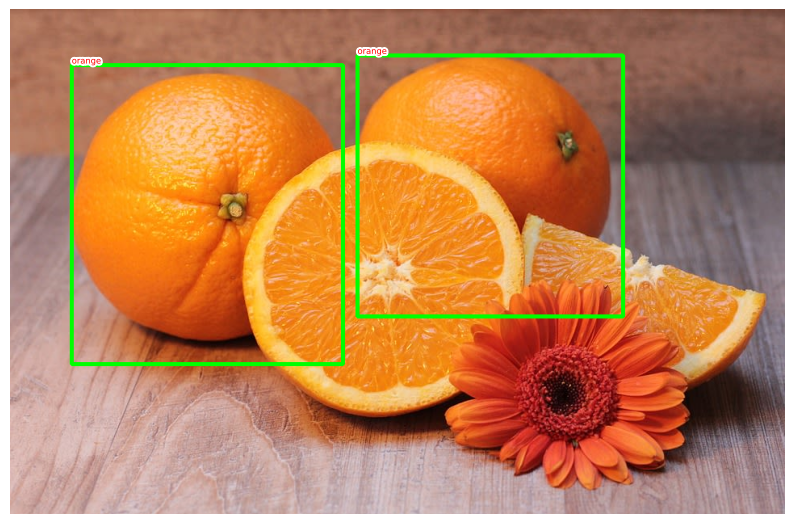

In [ ]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder='/content/train_zip/train/'):
        self.root = image_folder
#        self.root = [str(i) for i in self.root]
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}'
#        print(image_path)
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
#        print(image.shape)
#        print(image)
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=df_train)
im, bbs, clss, _ = ds[3]
show(im, bbs=bbs, texts=clss, sz=10)

In [ ]:
im

In [ ]:
bbs

[[76, 69, 412, 439], [430, 57, 759, 380]]

In [ ]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [ ]:
df_test.sample(2)

,ImageID,LabelName,way_pic,way_ann,XMin,YMin,XMax,YMax,width,height
12,banana_85.jpg,banana,/content/test_zip/test/banana_85.jpg,/content/test_zip/test/banana_85.xml,0.156402,0.197211,0.971258,0.686587,2679.0,1506.0
78,apple_86.jpg,apple,/content/test_zip/test/apple_86.jpg,/content/test_zip/test/apple_86.xml,0.588235,0.496454,0.757647,0.762411,425.0,282.0


In [ ]:
train = '/content/train_zip/train'
test = '/content/test_zip/test'

In [ ]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir):

        list_pic = []
        lst = [str(i) for i in Glob(image_dir)]
        for i in lst:
          if i.split('.')[1] == 'jpg':
            list_pic.append(i)
          else: continue

        self.image_dir = image_dir
        self.files = list_pic
        self.df = df
        self.image_infos = df.ImageID.unique()
#        print(self.image_infos)
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = self.df.iloc[ix]['way_pic']
#        print(img_path)
#        img = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values

        data[:,[0]] *= self.w
        data[:,[1]] *= self.h
        data[:,[2]] *= self.w
        data[:,[3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        #torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
#        print(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    def __len__(self):
        return len(self.image_infos)

In [ ]:
from sklearn.model_selection import train_test_split
#trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
#print(trn_ids, val_ids)
#trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
#print(trn_df, val_df)
#len(trn_df), len(val_df)
#----------------------------------------------------------------------------
# Удаляем картинки с очень маленькими коробками (т.к. после преобразований значения
# могут сравняться и получится нулевое значение)
# df_little = trn_df[(trn_df['XMax'] - trn_df['XMin'] < 0.005) | (trn_df['YMax'] - trn_df['YMin'] < 0.005)]
# lst = list(df_little.ImageID)
# print(f'Картинки в которых есть очень маленькие коробки удаляем для train:\n{lst}')
# trn_df = trn_df[trn_df.ImageID.isin(lst) == False]

# df_l = val_df[(val_df['XMax'] - val_df['XMin'] < 0.007) | (val_df['YMax'] - val_df['YMin'] < 0.007)]
# lst = list(df_l.ImageID)
# print(f'Картинки в которых есть очень маленькие коробки удаляем для val:\n{lst}')
# val_df = val_df[val_df.ImageID.isin(lst) == False]
#----------------------------------------------------------------------------
train_ds = OpenDataset(df_train, train)
test_ds = OpenDataset(df_test, test)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
for i,j in enumerate(train_ds):
  if i < 3:
   print(j)
  else: break



---



---



---



---



---



# **Создаем модель**



---



---



**Разбираемся с моделью**

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

In [ ]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
in_features

1024

In [ ]:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model

In [ ]:
unfreeze_layers = [model.backbone.body.layer4, model.backbone.fpn, model.roi_heads, model.rpn.head]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:

for param in model.parameters():
  param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

backbone.body.conv1.weight False

backbone.body.layer1.0.conv1.weight False

backbone.body.layer1.0.conv2.weight False

backbone.body.layer1.0.conv3.weight False

backbone.body.layer1.0.downsample.0.weight False

backbone.body.layer1.1.conv1.weight False

backbone.body.layer1.1.conv2.weight False

backbone.body.layer1.1.conv3.weight False

backbone.body.layer1.2.conv1.weight False

backbone.body.layer1.2.conv2.weight False

backbone.body.layer1.2.conv3.weight False

backbone.body.layer2.0.conv1.weight False

backbone.body.layer2.0.conv2.weight False

backbone.body.layer2.0.conv3.weight False

backbone.body.layer2.0.downsample.0.weight False

backbone.body.layer2.1.conv1.weight False

backbone.body.layer2.1.conv2.weight False

backbone.body.layer2.1.conv3.weight False

backbone.body.layer2.2.conv1.weight False

backbone.body.layer2.2.conv2.weight False

backbone.body.layer2.2.conv3.weight False

backbone.body.layer2.3.conv1.weight False

backbone.body.layer2.3.conv2.weight False

backbone.body.layer2.3.conv3.weight False

backbone.body.layer3.0.conv1.weight False

backbone.body.layer3.0.conv2.weight False

backbone.body.layer3.0.conv3.weight False

backbone.body.layer3.0.downsample.0.weight False

backbone.body.layer3.1.conv1.weight False

backbone.body.layer3.1.conv2.weight False

backbone.body.layer3.1.conv3.weight False

backbone.body.layer3.2.conv1.weight False

backbone.body.layer3.2.conv2.weight False

backbone.body.layer3.2.conv3.weight False

backbone.body.layer3.3.conv1.weight False

backbone.body.layer3.3.conv2.weight False

backbone.body.layer3.3.conv3.weight False

backbone.body.layer3.4.conv1.weight False

backbone.body.layer3.4.conv2.weight False

backbone.body.layer3.4.conv3.weight False

backbone.body.layer3.5.conv1.weight False

backbone.body.layer3.5.conv2.weight False

backbone.body.layer3.5.conv3.weight False

backbone.body.layer4.0.conv1.weight True

backbone.body.layer4.0.conv2.weight True

backbone.body.layer4.0.conv3.weight True

backbone.body.layer4.0.downsample.0.weight True

backbone.body.layer4.1.conv1.weight True

backbone.body.layer4.1.conv2.weight True

backbone.body.layer4.1.conv3.weight True

backbone.body.layer4.2.conv1.weight True

backbone.body.layer4.2.conv2.weight True

backbone.body.layer4.2.conv3.weight True

backbone.fpn.inner_blocks.0.0.weight True

backbone.fpn.inner_blocks.0.0.bias True

backbone.fpn.inner_blocks.1.0.weight True

backbone.fpn.inner_blocks.1.0.bias True

backbone.fpn.inner_blocks.2.0.weight True

backbone.fpn.inner_blocks.2.0.bias True

backbone.fpn.inner_blocks.3.0.weight True

backbone.fpn.inner_blocks.3.0.bias True

backbone.fpn.layer_blocks.0.0.weight True

backbone.fpn.layer_blocks.0.0.bias True

backbone.fpn.layer_blocks.1.0.weight True

backbone.fpn.layer_blocks.1.0.bias True

backbone.fpn.layer_blocks.2.0.weight True

backbone.fpn.layer_blocks.2.0.bias True

backbone.fpn.layer_blocks.3.0.weight True

backbone.fpn.layer_blocks.3.0.bias True

rpn.head.conv.0.0.weight True

rpn.head.conv.0.0.bias True

rpn.head.cls_logits.weight True

rpn.head.cls_logits.bias True

rpn.head.bbox_pred.weight True

rpn.head.bbox_pred.bias True

roi_heads.box_head.fc6.weight True

roi_heads.box_head.fc6.bias True

roi_heads.box_head.fc7.weight True

roi_heads.box_head.fc7.bias True

roi_heads.box_predictor.cls_score.weight True

roi_heads.box_predictor.cls_score.bias True

roi_heads.box_predictor.bbox_pred.weight True

roi_heads.box_predictor.bbox_pred.bias True

In [ ]:
model



---



---



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features #1024
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 2
log = Report(n_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




---



---



In [ ]:
unfreeze_layers = [model.backbone.body.layer4, model.backbone.fpn, model.roi_heads, model.rpn.head]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

In [ ]:

for param in model.parameters():
  param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)



---



---



In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//2)==0: log.report_avgs(epoch+1)

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
save_path = 'FASTER_R-CNN_1_epoch.pth'
torch.save(model.state_dict(), save_path)
!du -hsc {save_path} # size of the model on disk

159M	FASTER_R-CNN_1_epoch.pth
159M	total




---



---



In [ ]:
df_test.ImageID.unique()

array(['orange_80.jpg', 'banana_82.jpg', 'apple_91.jpg', 'banana_80.jpg',
       'orange_90.jpg', 'orange_84.jpg', 'banana_77.jpg', 'apple_90.jpg',
       'banana_93.jpg', 'orange_77.jpg', 'banana_79.jpg', 'banana_83.jpg',
       'apple_77.jpg', 'apple_82.jpg', 'banana_94.jpg', 'mixed_23.jpg',
       'banana_92.jpg', 'apple_78.jpg', 'apple_80.jpg', 'orange_78.jpg',
       'apple_81.jpg', 'orange_79.jpg', 'orange_94.jpg', 'banana_87.jpg',
       'mixed_21.jpg', 'banana_86.jpg', 'mixed_24.jpg', 'apple_95.jpg',
       'orange_93.jpg', 'banana_81.jpg', 'orange_89.jpg', 'banana_90.jpg',
       'mixed_25.jpg', 'apple_89.jpg', 'orange_95.jpg', 'apple_92.jpg',
       'orange_85.jpg', 'banana_91.jpg', 'banana_84.jpg', 'banana_88.jpg',
       'apple_83.jpg', 'apple_79.jpg', 'apple_94.jpg', 'banana_78.jpg',
       'apple_86.jpg', 'orange_81.jpg', 'apple_88.jpg', 'banana_85.jpg',
       'apple_85.jpg', 'orange_82.jpg', 'mixed_22.jpg', 'banana_89.jpg',
       'apple_87.jpg', 'apple_93.jpg', 'apple_

**Выбираем картинку,обрабатываем,загружаем модель, используем**

In [ ]:
snow = df_test[df_test.ImageID == 'banana_78.jpg']
snow

,ImageID,LabelName,way_pic,way_ann,XMin,YMin,XMax,YMax,width,height
57,banana_78.jpg,banana,/content/test_zip/test/banana_78.jpg,/content/test_zip/test/banana_78.xml,0.448753,0.138889,0.858726,0.983333,361.0,360.0
58,banana_78.jpg,banana,/content/test_zip/test/banana_78.jpg,/content/test_zip/test/banana_78.xml,0.224377,0.044444,0.609418,0.966667,361.0,360.0


In [ ]:
картинка = OpenDataset(snow, test)
картинка_загрузка = DataLoader(картинка, batch_size=1, collate_fn=train_ds.collate_fn, drop_last=True)

In [ ]:
for i in картинка:
  pic = i[0]*255
  l = i[1]['boxes'].tolist()
  b = []
  for i in l:
    b.append(list(map(int, i)))
print(pic)
print(b)
show(pic, bbs=b, sz=10)
  #show(i[0],bbs=i[1]['boxes'].tolist())
  #print(i[1]['boxes'])
pic[1][100]

In [ ]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target:
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()

In [ ]:
load_path = '/content/FASTER_R-CNN_1_epoch.pth'
#model.load_state_dict(torch.load(load_path)) #  # строка при загрузке на GРU
model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu'))) # строка при загрузке на СРU

In [ ]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

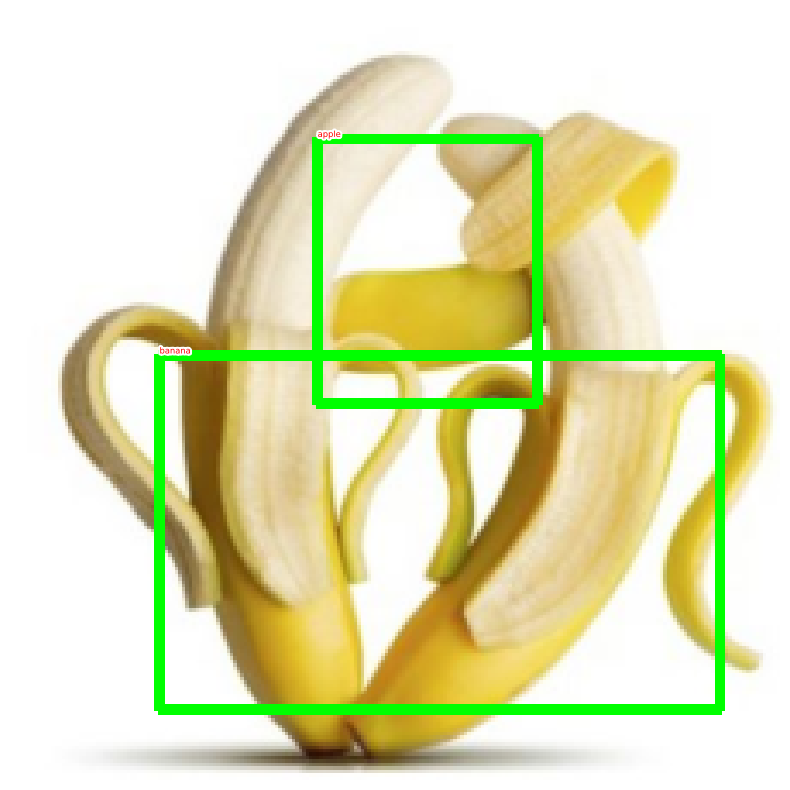

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(картинка_загрузка):
    if ix==4: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
#        if output['labels'] == 0:continue
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=10)

In [ ]:
image_paths = Glob(f'{DATA_ROOT}/JPEGImages/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

In [ ]:
image_paths = Glob(f'{DATA_ROOT}/JPEGImages/*')
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=50, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10,sz=5)
